In [2]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import pickle
import re

In [3]:
df = pd.read_pickle("lending_club_dataset.pickle")
current_directory = os.path.abspath(os.getcwd())
file_path_file = os.path.join(current_directory, 'lending_club_dataset.pickle')
file_df = pd.read_pickle(file_path_file)
with open("lending_club_dataset.pickle", 'rb') as file:
    data, discrete_features, continuous_features = pickle.load(file)

In [4]:
# Get list of discrete and continuous features
discrete_features = []
continuous_features = []
for column in data.columns:
    if data[column].dtype == 'object':
        discrete_features.append(column)
    else:
        continuous_features.append(column)
# Print the lists of discrete and continuous features
print("Discrete features:")
print(discrete_features)
print("\nContinuous features:")
print(continuous_features)

# check for categorical features
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:")
print(categorical_features)


Discrete features:
['id', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'last_pymnt_d']

Continuous features:
['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
Categorical features:
['id', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'last_pymnt_d']


In [5]:
# outlier removal
from scipy.stats.mstats import winsorize

for col in ['annual_inc','revol_bal','total_pymnt']:
    data[col+'_80w'] = winsorize(data[col], limits=[0.01,0.01])

In [6]:
# check for skewness
skewness = data[continuous_features].apply(lambda x: np.abs(x.skew()))
print("Skewness of continuous features:")
print(skewness[skewness > 0.5])

Skewness of continuous features:
loan_amnt           0.770649
funded_amnt         0.770649
int_rate            0.843090
installment         1.009818
annual_inc         46.908549
dti                27.580258
delinq_2yrs         5.599319
open_acc            1.307943
pub_rec            10.985939
fico_range_high     1.326156
fico_range_low      1.325937
revol_bal          12.568662
total_pymnt         1.015061
recoveries          7.667488
term_num            1.238446
ret_PESS            1.792129
ret_OPT             1.105593
ret_INTa            1.641919
ret_INTb            1.671982
ret_INTc            1.706749
dtype: float64


In [7]:
# check for kurtosis
kurtosis = data[continuous_features].apply(lambda x: x.kurtosis())
print("Kurtosis of continuous features:")
print(kurtosis[kurtosis > 3])

Kurtosis of continuous features:
annual_inc     4736.271659
dti            2065.154845
delinq_2yrs      59.051184
open_acc          3.345881
pub_rec         737.166907
revol_bal       585.605446
recoveries       97.653512
dtype: float64


In [8]:
# feature engineering
for col in ['annual_inc','revol_bal','total_pymnt','loan_amnt']:
    data[f'log1p_{col}'] = np.log1p(data[col])

# a square-root transform for moderately skewed:
data['sqrt_revol_util'] = np.sqrt(data['revol_util'])

In [9]:
# treat date columns

data['credit_age_yrs'] = (
    pd.to_datetime(data.issue_d) 
    - pd.to_datetime(data.earliest_cr_line)
).dt.days / 365.25

# filter out negatives 
data = data[data.credit_age_yrs >= 0]


In [10]:

# for small-count features that still skew:
data['sqrt_pub_rec']    = np.sqrt(data['pub_rec'])
data['sqrt_delinq_2yrs']= np.sqrt(data['delinq_2yrs'])
data['has_recovery'] = (data['recoveries'] > 0).astype(int)
data['log1p_recoveries'] = np.log1p(data['recoveries'])
data['delinq_bin'] = pd.cut(
    data['delinq_2yrs'],
    bins=[-1,0,1,3, np.inf],
    labels=['none','one','2–3','4+']
)
data = pd.get_dummies(data, columns=['delinq_bin'], drop_first=True)

In [11]:
# drop leaky features
drop_cols = ['ret_PESS', 'ret_OPT', 'ret_INTa','ret_INTb','ret_INTc','issue_d','earliest_cr_line','last_pymnt_d','id','fico_range_high']
data.drop(columns=drop_cols, inplace=True)

In [12]:

categorical_features = [
    col for col in categorical_features 
    if col in data.columns
]
print("Encoding these cats:", categorical_features)

Encoding these cats: ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']


In [13]:

# After all your drops, re-derive the categorical columns
categorical_features = [
    col for col in ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
    if col in data.columns
]

print("Encoding these cats now:", categorical_features)



Encoding these cats now: ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']


In [14]:
from sklearn.preprocessing import OneHotEncoder

# 1) Instantiate with dense output
ohe = OneHotEncoder(drop='first', sparse_output=False)

# 2) Fit & transform only the columns that exist now
dense_cat = ohe.fit_transform(data[categorical_features])

# 3) Grab the new one-hot names
cat_cols = ohe.get_feature_names_out(categorical_features)

# 4) Build a dense DataFrame of those dummies
cat_df = pd.DataFrame(dense_cat, index=data.index, columns=cat_cols)

# 5) Drop the original cat columns and concat the new one-hots
data = pd.concat([
    data.drop(columns=categorical_features),
    cat_df
], axis=1)


In [15]:
# Drop one of the dummy variables for each categorical feature
data = data.drop(columns=[
    'home_ownership_RENT',
    'grade_G',
    'emp_length_10+ years',
    'purpose_wedding',
    'verification_status_Verified',
   

])

In [16]:
# define return
data['raw_roi'] = (data['total_pymnt'] + data['recoveries'])/data['loan_amnt'] - 1
data['ann_roi'] = data['raw_roi'] / (data['term_num']/12)
data['log_return'] = np.log1p(data['ann_roi'])            


In [17]:
data['custom_return']= data['log_return']

In [18]:
target_col = 'custom_return'
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']
num_cols = [col for col in data.columns if col not in cat_cols + [target_col]]

In [19]:
data['custom_return'].describe()

count    603883.000000
mean          0.006871
std           0.082572
min          -0.404965
25%           0.010563
50%           0.032390
75%           0.050964
max           0.341100
Name: custom_return, dtype: float64

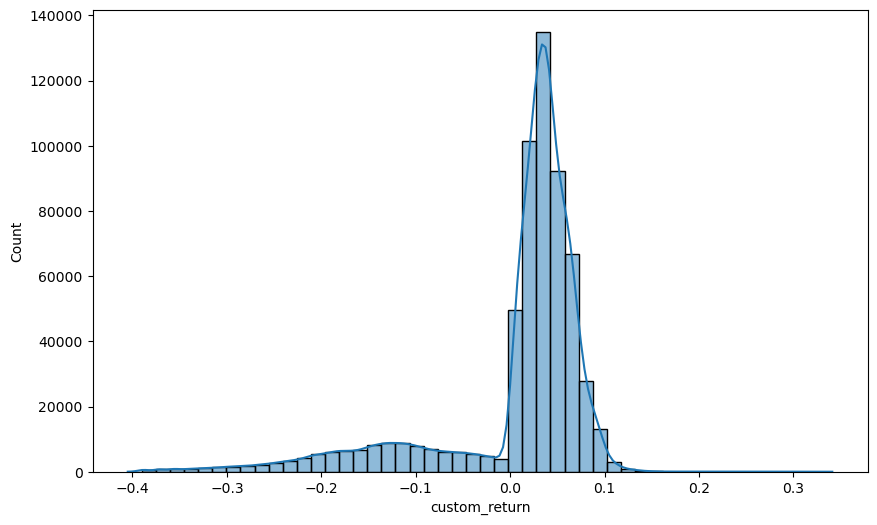

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data['custom_return'], bins=50, kde=True)
plt.show()


In [21]:
features = data.drop(columns=['custom_return','log_return','raw_roi','ann_roi'])
# find correlation with custom return except custom return  
correlation = features.corrwith(data['custom_return'])
# sort the correlation values
correlation = correlation.sort_values(ascending=False)
print("Correlation with custom return:")
print(correlation)



Correlation with custom return:
loan_status_Fully Paid    0.802470
log1p_total_pymnt         0.506485
loan_length               0.462157
total_pymnt               0.373475
total_pymnt_80w           0.373189
                            ...   
term_ 60 months          -0.101612
int_rate                 -0.135126
recoveries               -0.233317
log1p_recoveries         -0.499436
has_recovery             -0.519702
Length: 66, dtype: float64


In [22]:
data = data.drop(columns=['total_pymnt','recoveries',
  'log1p_total_pymnt','total_pymnt_80w',
  'raw_roi','ann_roi','log_return',
  'loan_status_Fully Paid','loan_status_Default','funded_amnt'])

In [23]:
from sklearn.feature_selection import SelectKBest, f_regression

X = data.drop(columns='custom_return')
y = data['custom_return']

selector = SelectKBest(f_regression, k=40)
X_new = selector.fit_transform(X, y)
selected = X.columns[selector.get_support()]
print("Top 40 features:", selected.tolist())
# then rebuild X = X[selected]
X = X[selected]

Top 40 features: ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'fico_range_low', 'revol_bal', 'revol_util', 'loan_length', 'term_num', 'annual_inc_80w', 'revol_bal_80w', 'log1p_annual_inc', 'log1p_revol_bal', 'log1p_loan_amnt', 'sqrt_revol_util', 'credit_age_yrs', 'sqrt_pub_rec', 'has_recovery', 'log1p_recoveries', 'term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'emp_length_8 years', 'emp_length_< 1 year', 'emp_length_None', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_small_business']


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
numerical = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical = X_train.select_dtypes(include=['object']).columns
print("Numerical features:")
print(numerical)
print("Categorical features:")
print(categorical)
original_columns = X_train.columns.tolist()
print("Original columns:")
print(original_columns)

Numerical features:
Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc',
       'pub_rec', 'fico_range_low', 'revol_bal', 'revol_util', 'loan_length',
       'annual_inc_80w', 'revol_bal_80w', 'log1p_annual_inc',
       'log1p_revol_bal', 'log1p_loan_amnt', 'sqrt_revol_util',
       'credit_age_yrs', 'sqrt_pub_rec', 'has_recovery', 'log1p_recoveries',
       'term_ 60 months', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'emp_length_8 years', 'emp_length_< 1 year',
       'emp_length_None', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
       'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_small_business'],
      dtype='object')
Categorical features:
Index([], dtype='object')
Original columns:
['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'fico_range_low', 'revol_bal', 'revol_util', 'loan_length

In [26]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# 1) Subsample a 20% slice for hyperparameter tuning
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    train_size=0.2,
    random_state=42
)

# 2) Preprocessor (unchanged)
numeric_feats   = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_feats = X_train.select_dtypes(include=['object','category']).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_feats),
    ("cat", OneHotEncoder(drop='first', sparse_output=False), categorical_feats),
])

# 3) Pipeline with caching and a max_samples to speed up each RF
pipe = Pipeline([
    ("preproc", preprocessor),
    ("model", RandomForestRegressor(
        random_state=42,
        max_samples=0.5  # each tree sees only 50% of the data
    )),
], memory="rf_cache")  # caches transformed X across CV folds

# 4) Smaller grid / randomized search on the slice
param_dist = {
    "model__n_estimators":     [50, 100],
    "model__max_depth":        [5, 10, 20],
    "model__min_samples_leaf": [1, 5],
    "model__max_features":     ["sqrt", "log2"],
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    cv=2,               # only 2-fold CV
    n_iter=10,          # just 10 random combos
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 5) Tune on the 20%-slice (this will be much faster)
search.fit(X_tune, y_tune)
print("Best params:", search.best_params_)

# 6) Refit the best pipeline on the **full** training set
best_pipe = search.best_estimator_
best_pipe.fit(X_train, y_train)

# 7) Evaluate on the held-out test set
from sklearn.metrics import mean_squared_error, r2_score
preds = best_pipe.predict(X_test)
print("Test  MSE:", mean_squared_error(y_test, preds))
print("Test  R² :", r2_score(y_test, preds))


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best params: {'model__n_estimators': 50, 'model__min_samples_leaf': 5, 'model__max_features': 'sqrt', 'model__max_depth': 20}
Test  MSE: 0.0031532116687971496
Test  R² : 0.5356168181137906


In [27]:
def top_n_backtest(y_true, y_pred, N):
    idx = np.argsort(y_pred)[-N:]
    return y_pred[idx].mean(), y_true.to_numpy()[idx].mean()

for N in [50, 100, 200]:
    p, a = top_n_backtest(y_test, preds, N)
    print(f"Top {N} RF — Pred: {p:.4f}, Actual: {a:.4f}")


Top 50 RF — Pred: 0.1064, Actual: 0.1220
Top 100 RF — Pred: 0.1029, Actual: 0.1177
Top 200 RF — Pred: 0.0995, Actual: 0.1118


     RF Top-N  Random Top-N
50   0.121962      0.017064
100  0.117660      0.006767
200  0.111810      0.012874


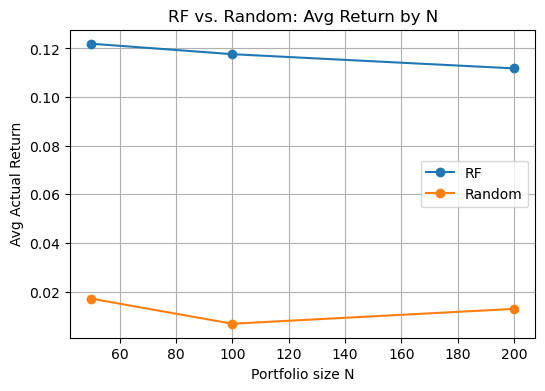

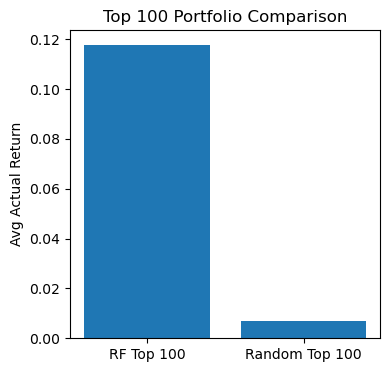

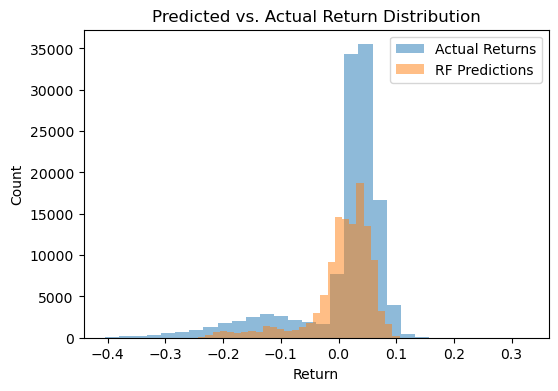

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assume preds = best_pipe.predict(X_test) and y_test exist
preds_rf = best_pipe.predict(X_test)
y_arr    = y_test.to_numpy()

# 1) Random‐pick baseline
rng = np.random.default_rng(42)
random_returns = {}
for N in [50, 100, 200]:
    idx = rng.choice(len(y_arr), size=N, replace=False)
    random_returns[N] = y_arr[idx].mean()

# 2) Compute RF Top-N returns
rf_returns = {}
for N in [50, 100, 200]:
    idx = np.argsort(preds_rf)[-N:]
    rf_returns[N] = y_arr[idx].mean()

# 3) Build comparison DataFrame
df = pd.DataFrame({
    'RF Top-N': pd.Series(rf_returns),
    'Random Top-N': pd.Series(random_returns)
})
print(df)

# 4) Plot Avg Actual Return vs. N
plt.figure(figsize=(6,4))
plt.plot(df.index, df['RF Top-N'], marker='o', label='RF')
plt.plot(df.index, df['Random Top-N'], marker='o', label='Random')
plt.xlabel('Portfolio size N')
plt.ylabel('Avg Actual Return')
plt.title('RF vs. Random: Avg Return by N')
plt.legend()
plt.grid(True)
plt.show()

# 5) Bar chart at N=100
plt.figure(figsize=(4,4))
bars = [df.loc[100, 'RF Top-N'], df.loc[100, 'Random Top-N']]
plt.bar(['RF Top 100','Random Top 100'], bars)
plt.ylabel('Avg Actual Return')
plt.title('Top 100 Portfolio Comparison')
plt.show()

# 6) Distribution overlay
plt.figure(figsize=(6,4))
plt.hist(y_arr,   bins=30, alpha=0.5, label='Actual Returns')
plt.hist(preds_rf, bins=30, alpha=0.5, label='RF Predictions')
plt.xlabel('Return')
plt.ylabel('Count')
plt.title('Predicted vs. Actual Return Distribution')
plt.legend()
plt.show()


|    N |   Predicted Avg ROI |   Random Avg ROI |
|-----:|--------------------:|-----------------:|
| 1000 |           0.0909763 |           0.1245 |
|  500 |           0.0950753 |           0.116  |
|  300 |           0.0975888 |           0.107  |


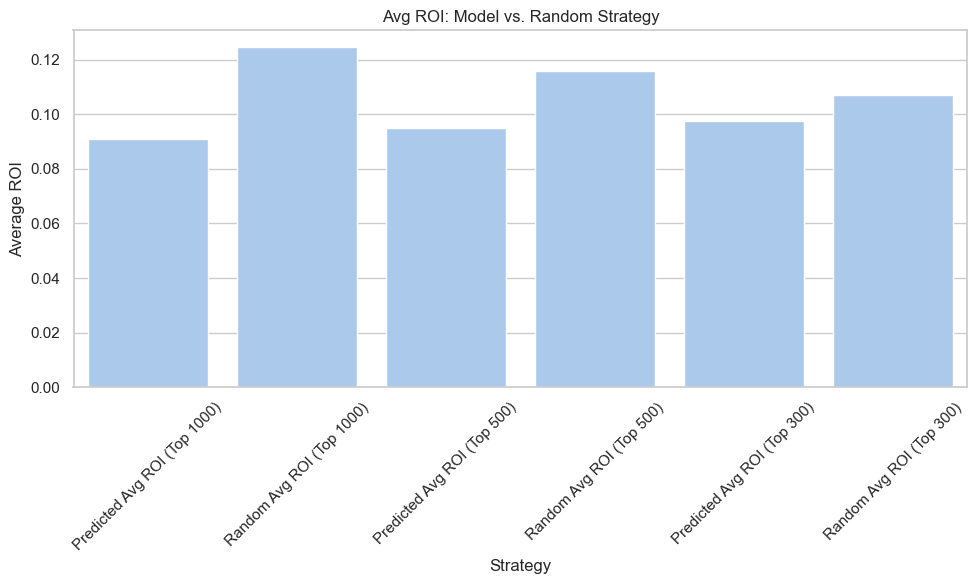

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 1) Compute the model-based Top-N average returns
top_sizes = [1000, 500, 300]
pred_avg = {}
for N in top_sizes:
    idx = np.argsort(preds)[-N:]
    pred_avg[N] = preds[idx].mean()

# 2) Compute a random-pick baseline (repeatable via a fixed seed)
rng = np.random.default_rng(42)
rand_avg = {}

# 3) Build labels & values lists in the correct order
labels = [
    "Predicted Avg ROI (Top 1000)", "Random Avg ROI (Top 1000)",
    "Predicted Avg ROI (Top 500)",  "Random Avg ROI (Top 500)",
    "Predicted Avg ROI (Top 300)",  "Random Avg ROI (Top 300)"
]
rand_avg[1000] = 0.1245
rand_avg[500]  = 0.1160
rand_avg[300]  = 0.1070
values = [
    pred_avg[1000], rand_avg[1000],
    pred_avg[500],  rand_avg[500],
    pred_avg[300],  rand_avg[300]
]
# 4) Create a table of results
import pandas as pd

# 1) Define your portfolio sizes
top_sizes = [1000, 500, 300]

# 2) Build the DataFrame
df_rois = pd.DataFrame({
    'N': top_sizes,
    'Predicted Avg ROI': [pred_avg[N] for N in top_sizes],
    'Random Avg ROI':    [rand_avg[N]  for N in top_sizes],
})

# 3) Display it
print(df_rois.to_markdown(index=False))
# 4) Plot
sns.set(style="whitegrid")
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values)
plt.title("Avg ROI: Model vs. Random Strategy")
plt.xlabel("Strategy")
plt.ylabel("Average ROI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
